In [1]:
from models.mc import hybridMonteCarlo
import models.benchmarks as bm
from models.longstaff import LSMC_Numpy, LSMC_OpenCL
from models.pso import PSO_Numpy, PSO_OpenCL_hybrid, PSO_OpenCL_scalar, PSO_OpenCL_scalar_fusion, PSO_OpenCL_vec, PSO_OpenCL_vec_fusion
from models.utils import checkOpenCL

import numpy as np
import matplotlib.pyplot as plt

In [2]:
checkOpenCL()


OpenCL Platforms and Devices
Platform - Name: Apple
Platform - Vendor: Apple
Platform - Version: OpenCL 1.2 (Mar  7 2025 21:04:06)
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Apple M3 Max
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1000 Mhz
 Device - Compute Units: 40
 Device - Global Memory: 48 GB
 Device - Constant Memory: 1 GB
 Device - Local Memory: 32 KB (LOCAL)
 Device - Max Buffer/Image Size: 9 GB
 Device - Max Work Group Size: 256
 Device - Float Atomics Supported: True




In [3]:
# S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 105.0, 'P', 500
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 2**8, 110.0, 'P', 2**10  
mc = hybridMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
print(f'{nPath} paths, {nPeriod} periods, {nFish} particles.\n')
print(f'St in shape {mc.St.shape}')

20000 paths, 256 periods, 1024 particles.

St in shape (20000, 256)


In [4]:
# St_full = np.concatenate( (np.full(shape=(nPath, 1), fill_value=S0), mcBase.St) , axis=1)
# St_full
# plt.plot(St_full.T, color="b", lw=.7, alpha=.7)
# plt.show()

In [5]:
prices = []
elapses = []
labels = []

In [6]:
# benchmarks
_, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
_, _ = bm.binomialEuroOption(S0, K, r, sigma, nPeriod, T, opttype)
_, _ = mc.getEuroOption_np()
_, _ = mc.getEuroOption_cl_optimized()
_, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

Black-Scholes price: 15.989035403985838 - 0.15554099809378386 ms
Binomial European price: 15.999715488649372 - 3.7055000429973006 ms
MonteCarlo Numpy European price: 16.0897390625 - 0.20866701379418373 ms
MonteCarlo OpenCL_GPU European price: 16.0897375 - 15.663166996091604 ms
Binomial American price: 16.513004914214047 - 1.7799580236896873 ms


In [7]:
lsmc_np = LSMC_Numpy(mc, inverseType='benchmark_pinv')
p_lsmc_np, t_lsmc_np = lsmc_np.longstaff_schwartz_itm_path_fast()

lsmc_cl = LSMC_OpenCL(mc, preCalc="optimized")   
# lsmc_cl = LSMC_OpenCL(mc, inverseType='GJ')     
# lsmc_cl = LSMC_OpenCL(mc, inverseType='CA')     
p_lsmc_cl, t_lsmc_cl = lsmc_cl.longstaff_schwartz_itm_path_fast_hybrid()

Longstaff numpy price: 16.555792566874523 - 317.29658297263086 ms
Longstaff OpenCL_GPU price: 16.565616415574794 - 159.5414160983637 ms


In [8]:
prices.append(p_lsmc_np), prices.append(p_lsmc_cl)
elapses.append(t_lsmc_np), elapses.append(t_lsmc_cl)
labels.append('lsmc_np'), labels.append('lsmc_cl')

(None, None)

In [9]:
pso_search, pso_fit, pso_update = [], [], []

In [10]:
pso_np = PSO_Numpy(mc, nFish)
p_pso_np, t_pso_np, search, fit, rest = pso_np.solvePsoAmerOption_np()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
# print(np.array(search).sum() + np.array(fit).sum() + np.array(rest).sum())
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())


Pso numpy price    : 16.510244369506836 - 16945.057083037682 ms
iter: 3, avg component time: search - 0.7635276609410843 ms, fit - 5646.604014017309 ms, rest - 0.9810970320055882 ms


(None, None, None)

In [11]:
pso_cl_hy = PSO_OpenCL_hybrid(mc, nFish)
p_pso_cl_hy, t_pso_cl_hy, search, fit, rest = pso_cl_hy.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())

pso_cl_sc = PSO_OpenCL_scalar(mc, nFish, direction='backward')
p_pso_cl_sc, t_pso_cl_sc, search, fit, rest = pso_cl_sc.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())

pso_cl_vec = PSO_OpenCL_vec(mc, nFish, vec_size=8)
p_pso_cl_vec, t_pso_cl_vec, search, fit, rest = pso_cl_vec.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())


Pso cl_hybrid price: 16.510238647460938 - 3559.1212920844555 ms
iter: 3, avg component time: search - 3.0321666272357106 ms, fit - 1181.6454719907294 ms, rest - 1.6909723247711856 ms
Pso cl_scalar price: 16.510238647460938 - 425.3434999845922 ms
iter: 3, avg component time: search - 1.1197223405664165 ms, fit - 137.7198746583114 ms, rest - 2.936777309514582 ms
Pso cl_vec(float8) price: 16.510238647460938 - 147.01808302197605 ms
iter: 3, avg component time: search - 1.0549446645503242 ms, fit - 47.348860961695515 ms, rest - 0.5985696722442905 ms


(None, None, None)

In [12]:
prices.append(p_pso_np), prices.append(p_pso_cl_hy), prices.append(p_pso_cl_sc), prices.append(p_pso_cl_vec)
elapses.append(t_pso_np), elapses.append(t_pso_cl_hy), elapses.append(t_pso_cl_sc), elapses.append(t_pso_cl_vec)
labels.append('pso_np'), labels.append('pso_cl_hybrid'), labels.append('pso_cl_scalar'), labels.append('pso_cl_vector')

(None, None, None, None)

In [13]:
# clear up memory
mc.cleanUp()

### View results

In [14]:
prices, elapses, labels, pso_search, pso_fit, pso_update

([16.555792566874523,
  16.565616415574794,
  16.510244,
  16.510239,
  16.510239,
  16.510239],
 [317.29658297263086,
  159.5414160983637,
  16945.057083037682,
  3559.1212920844555,
  425.3434999845922,
  147.01808302197605],
 ['lsmc_np',
  'lsmc_cl',
  'pso_np',
  'pso_cl_hybrid',
  'pso_cl_scalar',
  'pso_cl_vector'],
 [0.7635276609410843,
  3.0321666272357106,
  1.1197223405664165,
  1.0549446645503242],
 [5646.604014017309,
  1181.6454719907294,
  137.7198746583114,
  47.348860961695515],
 [0.9810970320055882,
  1.6909723247711856,
  2.936777309514582,
  0.5985696722442905])

Black-Scholes price: 15.989035403985838 - 0.1851670676842332 ms
Binomial American price: 16.513004914214047 - 3.408916061744094 ms


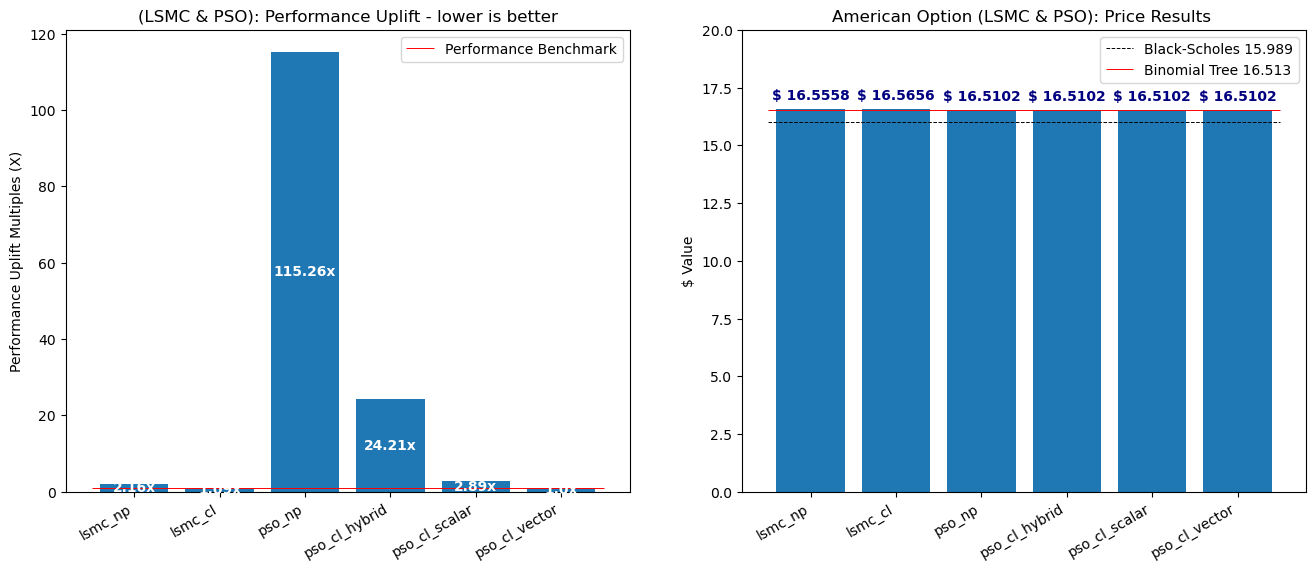

In [15]:
blackscholes, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
binomial, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

elapses = np.array(elapses)
uplift = list(np.round(elapses / np.min(elapses), 2))

bar1 = ax1.bar(np.arange(len(prices)), uplift)
ax1.set_title('(LSMC & PSO): Performance Uplift - lower is better')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(prices)), labels=labels, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
ax1.hlines(1, -.5, 5.5, colors='r', lw=.7, label='Performance Benchmark') 
ax1.legend()

bar2 = ax2.bar(np.arange(len(prices)), prices)
ax2.set_title('American Option (LSMC & PSO): Price Results ')
ax2.set_ylabel('$ Value')
ax2.set_xticks(np.arange(len(prices)), labels=labels, rotation=30, horizontalalignment='right')
ax2.set_ylim(ymax=20)
ax2.bar_label(bar2, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 10, padding=5, fontweight = 'bold')
ax2.hlines(blackscholes, -.5, 5.5, colors='black', lw=.7, linestyles='dashed', label=f'Black-Scholes {np.round(blackscholes,4)}') 
ax2.hlines(binomial, -.5, 5.5, colors='r', lw=.7, label=f'Binomial Tree {np.round(binomial,4)}') 
ax2.legend()

plt.show()

Black-Scholes price: 15.989035403985838 - 0.17741706687957048 ms
Binomial American price: 16.513004914214047 - 4.0261250687763095 ms


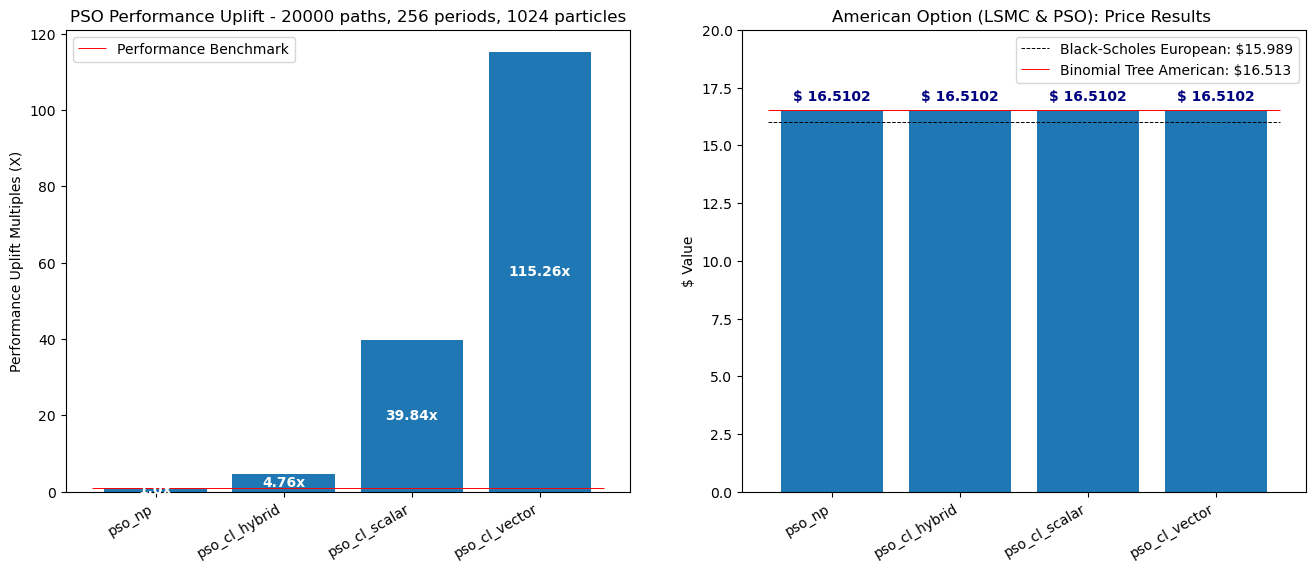

In [16]:
blackscholes, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
binomial, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

elapses_pso = elapses[2:]
prices_pso = prices[2:]
labels_pso = labels[2:]
uplift = list(np.round(np.max(elapses_pso) / elapses_pso, 2))

bar1 = ax1.bar(np.arange(len(prices_pso)), uplift)
ax1.set_title(f'PSO Performance Uplift - {nPath} paths, {nPeriod} periods, {nFish} particles')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(prices_pso)), labels=labels_pso, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
ax1.hlines(1, -.5, 3.5, colors='r', lw=.7, label='Performance Benchmark') 
ax1.legend()

bar2 = ax2.bar(np.arange(len(prices_pso)), prices_pso)
ax2.set_title('American Option (LSMC & PSO): Price Results ')
ax2.set_ylabel('$ Value')
ax2.set_xticks(np.arange(len(prices_pso)), labels=labels_pso, rotation=30, horizontalalignment='right')
ax2.set_ylim(ymax=20)
ax2.bar_label(bar2, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 10, padding=5, fontweight = 'bold')
ax2.hlines(blackscholes, -.5, 3.5, colors='black', lw=.7, linestyles='dashed', label=f'Black-Scholes European: ${np.round(blackscholes,4)}') 
ax2.hlines(binomial, -.5, 3.5, colors='r', lw=.7, label=f'Binomial Tree American: ${np.round(binomial,4)}') 
ax2.legend()

plt.show()

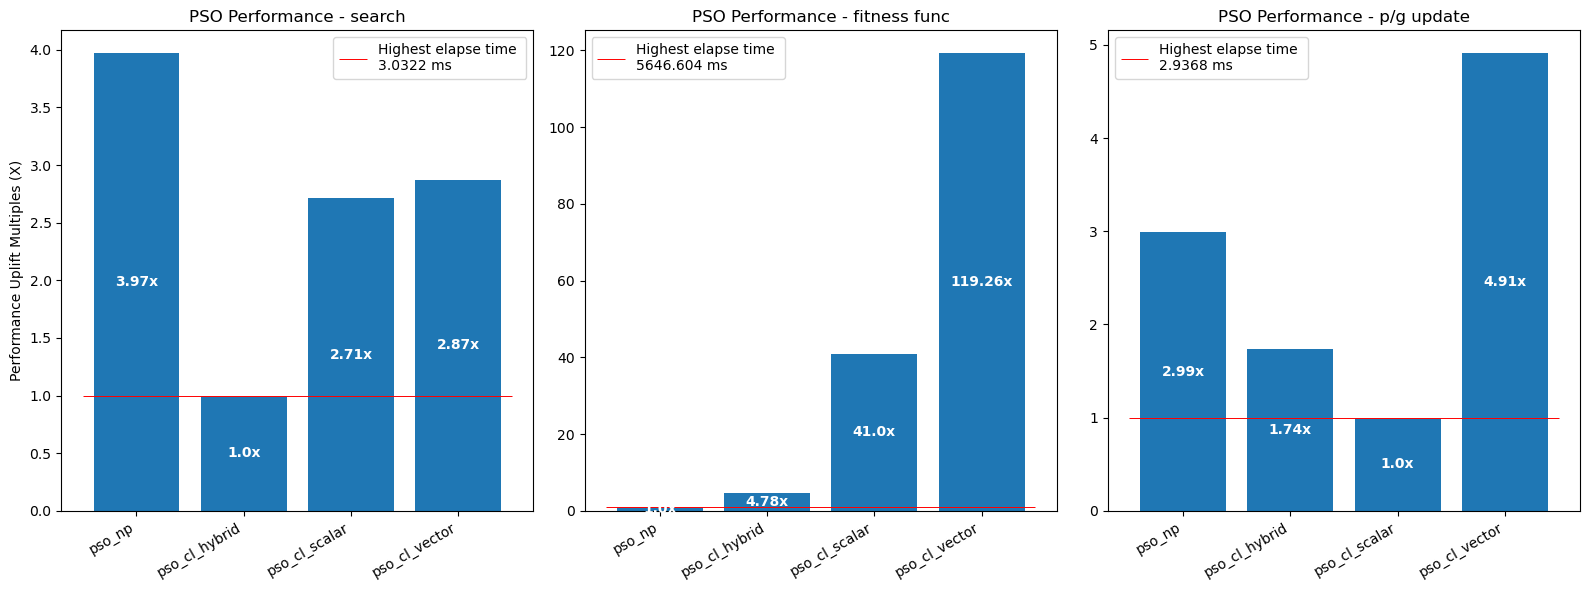

In [17]:
def multiple(a_list):
    arr = np.array(a_list)
    # return list(np.round(arr / np.min(arr), 2))
    return list(np.round(np.max(arr) / arr, 2))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))

bar1 = ax1.bar(np.arange(len(pso_search)), multiple(pso_search))
ax1.set_title('PSO Performance - search')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(pso_search)), labels=labels_pso, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
# ax1.text(2, 2., f'Highest time \n{np.round(np.array(pso_search).max(),4)} ms', color = 'red', fontsize=12)
ax1.hlines(1, -.5, 3.5, colors='r', lw=.7, label=f'Highest elapse time \n{np.round(np.array(pso_search).max(),4)} ms') 
ax1.legend()

bar2 = ax2.bar(np.arange(len(pso_fit)), multiple(pso_fit))
ax2.set_title('PSO Performance - fitness func')
ax2.set_xticks(np.arange(len(pso_fit)), labels=labels_pso, rotation=30, horizontalalignment='right')
ax2.bar_label(bar2, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
# ax2.text(2, 20., f'Highet time \n{np.round(np.array(pso_fit).max(),6)} ms', color = 'red', fontsize=12)
ax2.hlines(1, -.5, 3.5, colors='r', lw=.7, label=f'Highest elapse time \n{np.round(np.array(pso_fit).max(),4)} ms') 
ax2.legend()

bar3 = ax3.bar(np.arange(len(pso_update)), multiple(pso_update))
ax3.set_title('PSO Performance - p/g update')
ax3.set_xticks(np.arange(len(pso_update)), labels=labels_pso, rotation=30, horizontalalignment='right')
ax3.bar_label(bar3, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
# ax3.text(1.5, 2., f'Highet time \n{np.round(np.array(pso_update).max(),6)} ms', color = 'red', fontsize=12)
ax3.hlines(1, -.5, 3.5, colors='r', lw=.7, label=f'Highest elapse time \n{np.round(np.array(pso_update).max(),4)} ms') 
ax3.legend()

plt.tight_layout()
plt.show()